# Some codes to demonstrate the functionalities needed to build the viewer.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np

In [3]:
import os
import sys

sys.path.append('..')

### 1. How to plot chemicals

Define the chemical generation parameters. Some settings are already defined inside `vimms_gym.viewer_helper`.

In [4]:
from vimms_gym.viewer_helper import preset_1

In [5]:
params = preset_1()
chemical_creator_params = params['chemical_creator']
chemical_creator_params

2022-06-30 23:12:03.789 
  command:

    streamlit run /opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]


{'mz_range': (100, 600),
 'rt_range': (200, 1000),
 'intensity_range': (10000.0, 10000000000.0),
 'n_chemicals': (2000, 5000),
 'mz_sampler': <vimms.ChemicalSamplers.UniformMZFormulaSampler at 0x7f9fb1a3e070>,
 'ri_sampler': <vimms.ChemicalSamplers.UniformRTAndIntensitySampler at 0x7f9fb1a3e0d0>,
 'cr_sampler': <vimms.ChemicalSamplers.GaussianChromatogramSampler at 0x7f9fb1a3e100>}

Generate a bunch of chemicals by calling the helper method defined inside `vimms_gym.viewer_helper`.

In [6]:
from vimms_gym.chemicals import generate_chemicals

In [7]:
chems = generate_chemicals(chemical_creator_params)
len(chems)

2022-06-30 23:12:06.049 | DEBUG    | vimms.Chemicals:sample:468 - Sampled rt and intensity values and chromatograms


4030

Let's inspect the first chemical object. We can see below it's of type `UnknownChemical`, which is defined here: https://github.com/glasgowcompbio/vimms/blob/master/vimms/Chemicals.py#L291-L323.

In [8]:
first = chems[0]
first

UnknownChemical mz=372.1457 rt=695.34 max_intensity=1784255085.20

The chemical has an `rt` property, which indicates the **start** of the chromatogram (when the chemical begins to elute through the mass spec).

In [9]:
first.rt

695.3390813860677

Get the complete chromatogram of this chemical. Here we see it's of type `FunctionalChromatogram`, which is defined here: https://github.com/glasgowcompbio/vimms/blob/master/vimms/Chromatograms.py#L151-L206.

In [10]:
chrom = first.chromatogram
chrom

A chromatogram has a defined range, stored inside the `min_rt` and `max_rt` property. Notice that it starts from 0.

In [11]:
chrom.min_rt, chrom.max_rt

(0, 51.51658607097801)

We can plot the chromatogram for its entire range.

First generate a linearly-spaced grid for the X axis (you can also use for-loop to do this, instead of numpy).

In [12]:
X = np.linspace(chrom.min_rt, chrom.max_rt, num=20)
X

array([ 0.        ,  2.71139927,  5.42279853,  8.1341978 , 10.84559707,
       13.55699633, 16.2683956 , 18.97979487, 21.69119414, 24.4025934 ,
       27.11399267, 29.82539194, 32.5367912 , 35.24819047, 37.95958974,
       40.670989  , 43.38238827, 46.09378754, 48.8051868 , 51.51658607])

Then call `get_relative_intensity` method of the chromatogram for each timepoint in X to get the relative intensity of this chromaoram.

In [13]:
Y_relative = np.array([chrom.get_relative_intensity(x) for x in X])
Y_relative

array([0.0362452 , 0.07024286, 0.12648119, 0.21160294, 0.32891941,
       0.47503908, 0.63744278, 0.79474006, 0.92062134, 0.99085249,
       0.99085249, 0.92062134, 0.79474006, 0.63744278, 0.47503908,
       0.32891941, 0.21160294, 0.12648119, 0.07024286, 0.0362452 ])

Remember that X has been shifted by `first.rt`, so we need to add it back.

Text(0, 0.5, 'Relative intensity')

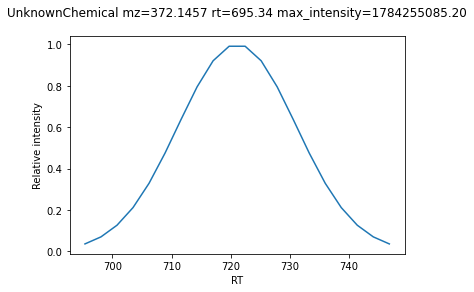

In [14]:
rt = X + first.rt
plt.plot(rt, Y_relative)
plt.title(first, pad=20)
plt.xlabel('RT')
plt.ylabel('Relative intensity')

Above shows the relative intensity of this chemical (goes from 0 to 1). What if we want to get the absolute intensity that is actually measured by the mass spec.

Some complex-looking function that I should document later ...

In [15]:
from vimms.Common import POSITIVE

In [16]:
def get_chemical_max_intensity(chem, ionisation_mode=POSITIVE, which_isotope=0, which_adduct=0):
    return chem.isotopes[which_isotope][1] * \
           chem.adducts[ionisation_mode][which_isotope][1] * \
           chem.max_intensity

In [17]:
max_intensity = get_chemical_max_intensity(first)
max_intensity

1784255085.2031448

In [18]:
Y_absolute = Y_relative * max_intensity
Y_absolute

array([6.46706837e+07, 1.25331187e+08, 2.25674705e+08, 3.77553630e+08,
       5.86876134e+08, 8.47590893e+08, 1.13736052e+09, 1.41801899e+09,
       1.64262331e+09, 1.76793359e+09, 1.76793359e+09, 1.64262331e+09,
       1.41801899e+09, 1.13736052e+09, 8.47590893e+08, 5.86876134e+08,
       3.77553630e+08, 2.25674705e+08, 1.25331187e+08, 6.46706837e+07])

Text(0, 0.5, 'Absolute intensity')

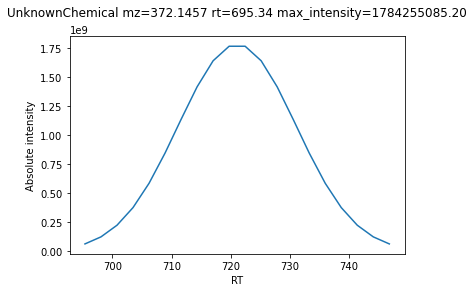

In [19]:
rt = X + first.rt
plt.plot(rt, Y_absolute)
plt.title(first, pad=20)
plt.xlabel('RT')
plt.ylabel('Absolute intensity')

### 2. Simulate fragmentation using the chosen method

Once we have the input chems, we can simulate the fragmentation process. Some of the codes below are similar to those inside `vimms_gym.viewer_helper`.

First load the trained PPO model.

In [20]:
from stable_baselines3 import PPO

In [21]:
in_dir = os.path.abspath(os.path.join('simulated_chems', 'results'))
env_name = 'DDAEnv'
model_name = 'PPO'
fname = os.path.join(in_dir, '%s_%s.zip' % (env_name, model_name))
model = PPO.load(fname)
model

Run fragmentation using the model. Below code is almost the same to `vimms_gym.viewer_helper.run_simulation`, but without the streamlit bits.

In [22]:
from vimms_gym.env import DDAEnv
from vimms_gym.common import METHOD_PPO, METHOD_TOPN
from vimms_gym.evaluation import Episode, pick_action

In [23]:
max_peaks = 200 # what we used for training the model ... this really should be a part of params

In [24]:
method = METHOD_PPO

In [25]:
# only used for Top-N method
min_ms1_intensity = 5000
N = 20  # from optimise_baselines.ipynb
rt_tol = 30  # from optimise_baselines.ipynb

In [26]:
env = DDAEnv(max_peaks, params)
obs = env.reset(chems=chems)
done = False
episode = Episode(obs)
while not done:  # repeat until episode is done

    # select an action depending on the observation and method
    action, action_probs = pick_action(
        method, obs, model, env.features, N, min_ms1_intensity)

    # make one step through the simulation
    obs, reward, done, info = env.step(action)

    # store new episodic information
    if obs is not None:
        episode.add_step_data(action, action_probs, obs, reward, info)

    if episode.num_steps % 500 == 0:
        print('Step\t', episode.num_steps, '\tTotal reward\t',
                 episode.get_total_rewards())

    # if episode is finished, break
    if done:
        msg = f'Episode stored into session: {episode.num_steps} timesteps ' \
              f'with total reward {episode.get_total_rewards()}'
        print(msg)
        break

Step	 500 	Total reward	 218.42429810820485
Step	 1000 	Total reward	 482.60285618280477
Step	 1500 	Total reward	 726.8996852530433
Step	 2000 	Total reward	 981.1480517196591
Step	 2500 	Total reward	 1215.7543695227178
Step	 3000 	Total reward	 1453.0700889796522
Step	 3500 	Total reward	 1712.1457081940127
Episode stored into session: 3650 timesteps with total reward 1782.879733060315


### 3. When does a particular chemical get fragmented, and in which scan?

Get all MS2 fragmentation events in the whole simulated run.

In [27]:
ms2_frags = [e for e in env.vimms_env.mass_spec.fragmentation_events if e.ms_level == 2]
ms2_frags[0:10]

[MS2 ScanEvent for UnknownChemical mz=596.9183 rt=200.13 max_intensity=4228115754.49 at 201.000000,
 MS2 ScanEvent for UnknownChemical mz=511.8607 rt=200.01 max_intensity=2988332.89 at 201.600000,
 MS2 ScanEvent for UnknownChemical mz=596.5535 rt=201.34 max_intensity=2337512.75 at 202.200000,
 MS2 ScanEvent for UnknownChemical mz=155.8298 rt=202.01 max_intensity=18106591.93 at 202.800000,
 MS2 ScanEvent for UnknownChemical mz=289.2857 rt=201.57 max_intensity=703461857.54 at 203.400000,
 MS2 ScanEvent for UnknownChemical mz=480.8472 rt=201.48 max_intensity=1371199.67 at 204.000000,
 MS2 ScanEvent for UnknownChemical mz=479.4236 rt=201.87 max_intensity=73997142.59 at 204.600000,
 MS2 ScanEvent for UnknownChemical mz=539.3465 rt=204.25 max_intensity=32511899.99 at 205.200000,
 MS2 ScanEvent for UnknownChemical mz=356.0747 rt=202.17 max_intensity=19271.34 at 205.800000,
 MS2 ScanEvent for UnknownChemical mz=521.1645 rt=201.95 max_intensity=2832993.55 at 206.400000]

How do we know which chemical has been fragmented in which scan? You can check that using the `info` field returned by each step(), e.g. here using the last `info` value of the last MS2 scan, we can extract the scan id.

In [28]:
scan_id = info['current_scan'].scan_id
scan_id

103650

Filter frag events by the scan id above.

In [29]:
scan_events = [e for e in ms2_frags if e.scan_id == scan_id]
scan_events

[MS2 ScanEvent for UnknownChemical mz=173.9833 rt=983.41 max_intensity=199665.55 at 999.800000]

There could be multiple frag events associated to a scan, e.g. if multiple chemicals were fragmented, then there would be multiple frag events, one for each.
Here we take the first one for illustration purpose. We can see it's of type `ScanEvent`, defined here: https://github.com/glasgowcompbio/vimms/blob/master/vimms/MassSpec.py#L105-L145.

In [30]:
se = scan_events[0]
se

MS2 ScanEvent for UnknownChemical mz=173.9833 rt=983.41 max_intensity=199665.55 at 999.800000

Below shows how to extract the chemical, query (scan) RT and the associated scan id for this MS2 fragmentation event.

In [31]:
se.chem, se.query_rt, se.scan_id

(UnknownChemical mz=173.9833 rt=983.41 max_intensity=199665.55,
 999.8000000000723,
 103650)